In [27]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [204]:
df = pd.read_csv("train_feats.csv")

In [1]:
import os

In [1]:
# import findspark
# findspark.init()

# import pyspark
# import random

# sc = pyspark.SparkContext(appName="Pi")
# num_samples = 100000000

# def inside(p):     
#   x, y = random.random(), random.random()
#   return x*x + y*y < 1

# count = sc.parallelize(range(0, num_samples)).filter(inside).count()

# pi = 4 * count / num_samples
# print(pi)

# sc.stop()


3.1410592


In [2]:
import findspark  # Get rid of this in DataBricks
findspark.init()  # Get rid of this in DataBricks
from pyspark.sql import Row
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.types import FloatType
from pyspark.sql.types import DoubleType
from pyspark.sql.types import IntegerType

from pyspark.sql.functions import udf
from pyspark.sql import functions as F 
from pyspark.sql.functions import explode, col, udf, mean as _mean, stddev as _stddev, log, log10
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.functions import lit

from pyspark.ml.feature import StringIndexer

from pyspark.ml.feature import VectorAssembler


In [3]:
config = SparkConf().setAll([('spark.executor.memory', '12g'), ('spark.executor.cores', '5'), ('spark.cores.max', '7'), ('spark.driver.memory','8g')])
config.setAppName("proj")
config.set("spark.dynamicAllocation.minExecutors", "4");
config.set("spark.dynamicAllocation.maxExecutors", "8");
config.set("spark.dynamicAllocation.initialExecutors", "6"); # the number must be between the min and max
sc = SparkContext(conf=config)  # start a new sc with the current config
spark = SparkSession(sc)
sqlc=SQLContext(sc)
print(sc.getConf().getAll())  # print all the configuration

[('spark.app.id', 'local-1606576635033'), ('spark.dynamicAllocation.minExecutors', '4'), ('spark.executor.cores', '5'), ('spark.executor.id', 'driver'), ('spark.dynamicAllocation.initialExecutors', '6'), ('spark.executor.memory', '12g'), ('spark.cores.max', '7'), ('spark.rdd.compress', 'True'), ('spark.driver.memory', '8g'), ('spark.serializer.objectStreamReset', '100'), ('spark.master', 'local[*]'), ('spark.submit.pyFiles', ''), ('spark.submit.deployMode', 'client'), ('spark.dynamicAllocation.maxExecutors', '8'), ('spark.ui.showConsoleProgress', 'true'), ('spark.app.name', 'proj'), ('spark.driver.port', '36101'), ('spark.driver.host', 'nia-jupyter')]


In [5]:
sc.stop()

# Features correlations

The ideas of exmaing correlations among features is to only select features that have no strong correlations with any other features.

In [7]:
corr_matrix = df.iloc[:, 4:].corr()

In [18]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))


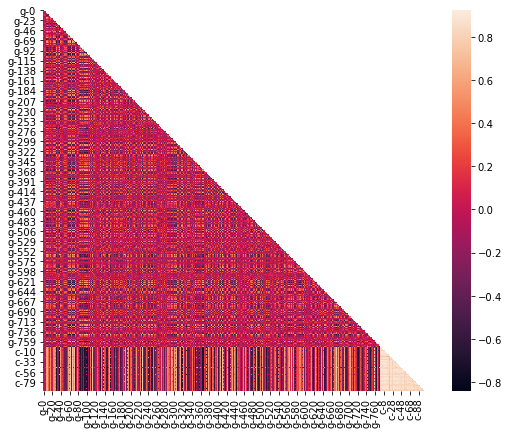

In [40]:
f, ax = plt.subplots(figsize=(10,7))

sns.heatmap(corr_matrix, mask=mask, square=True, ax = ax)

As seen, high correlations are observed among cell features. In the following steps, we are attamping to identify these features (and possibly drop them as well}) using pyspark approach

In [4]:
feature_df = spark.read.csv('train_feats.csv', header='true', inferSchema= 'true')   # path in HDFS file system

In [14]:
duplicates = feature_df.groupBy(train.columns).count().where(F.col('count') > 1).select(F.sum('count').alias('Duplicate Row Count')).collect()

Make sure that there are no duplicates and null values, from Jeff:

In [16]:
num_duplicate_rows = 0 if duplicates[0].__getitem__("Duplicate Row Count")==None else duplicates[0].__getitem__("Duplicate Row Count")
dropped_na_feature_df = feature_df.dropna(how="any", thresh=None, subset=None)
num_missing_rows = feature_df.count() - dropped_na_feature_df.count()
print('Number of duplicate rows in features dataframe: ', num_duplicate_rows)
print('Number of rows with missing value in features dataframe: ', num_missing_rows)

Number of duplicate rows in features dataframe:  0
Number of rows with missing value in features dataframe:  0


In [7]:
from pyspark.ml.stat import Correlation


Vectorize the feature dataframe

In [5]:
input_columns = [f"g-{i}" for i in range(772)] + [f"c-{i}" for i in range(100)]

vectorAssembler = VectorAssembler(inputCols =input_columns, outputCol = 'feats' )
feature_vector = vectorAssembler.transform(feature_df)

In [8]:
# pyspark implementation of determining the correlations
corr_matrix = Correlation.corr(feature_vector, "feats").head()[0]

In [47]:
# Convert the correlation desne matrix and apply mask and to get the indicies where high correlations are observed
corr_Array = corr_matrix.toArray()
masked_corr = np.ma.masked_where(np.triu(np.ones_like(corr_Array, dtype=bool)), corr_Array, copy=True)
idx_high_corr_feats = set(np.argwhere(masked_corr > 0.90)[:,0])

In [60]:
# Finally, obtain the dataframe but with high correation features dropped

feature_df_with_high_corr_dropped = feature_df.select(
                    ['sig_id', 'cp_type', 'cp_time', 'cp_dose'] + [col_name for i, col_name  in enumerate(input_columns) if i not in idx_high_corr_feats])

In [20]:
type(ff)

list

In [44]:
corr_df = spark.createDataFrame(corr_matrix.toArray().tolist())

In [54]:
fffff = corr_df.where(col("_10").between(5, 10))

In [ ]:
from pyspark.sql.window import Window

corr_df.withColumn("id", monotonically_increasing_id())


In [ ]:
corr_df.head()

In [ ]:
corr_df.withColumn("_id", monotonically_increasing_id())

In [63]:
from pyspark.sql import Seq

cols = Seq("firstname","middlename","lastname")

ImportError: cannot import name 'Seq'

In [64]:
corr_df.drop(cols = "_*")

TypeError: drop() got an unexpected keyword argument 'cols'

In [98]:
# Standardize each numeric column
from pyspark.ml.feature import VectorAssembler, StandardScaler, Normalizer

# Assemble all numeric features into one column before passing it to StandardScalar
# Learn more at - https://spark.apache.org/docs/latest/ml-features#standardscaler
features_vector_assembler = VectorAssembler(inputCols=input_columns, outputCol="std_numeric")
assembled_features_df = features_vector_assembler.transform(feature_df)

norm = Normalizer(inputCol="std_numeric", outputCol="scaledFeatures")
scaled_features_df = norm.transform(assembled_features_df)
# scaled_features_df = scaler_model.transform(assembled_features_df)

# The scaled features are grouped together in the scaledFeatures column
scaled_features_df.select('scaledFeatures').show()

+--------------------+
|      scaledFeatures|
+--------------------+
|[0.04760996788263...|
|[0.00337188691164...|
|[0.02205330792300...|
|[-0.0130185017848...|
|[-0.0115063761736...|
|[-0.0252337193978...|
|[0.02025497439596...|
|[0.00657421003697...|
|[-0.0122264149798...|
|[-0.0025116338093...|
|[-0.0143543460284...|
|[-0.0213034848413...|
|[1.10812737842825...|
|[-0.0239337967677...|
|[0.00589974691101...|
|[0.00252137213810...|
|[0.05546328289404...|
|[-0.0183344580082...|
|[-0.0167687690963...|
|[-0.0075339150817...|
+--------------------+
only showing top 20 rows



In [99]:
dfdf = scaled_features_df.select('scaledFeatures').collect()

In [100]:
sdfsd = [item['scaledFeatures'].toArray().tolist() for item in dfdf]

In [80]:
dfdf[0]['scaledFeatures'].toArray().tolist

<function ndarray.tolist>

In [101]:
import numpy as np
dfdfdfd = np.array(sdfsd)

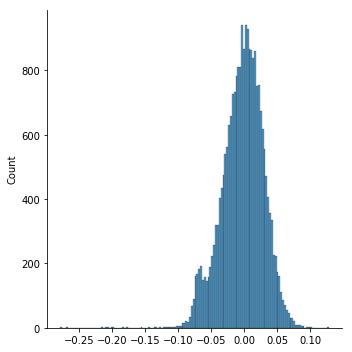

In [102]:
import seaborn as sns
sns.displot(dfdfdfd[:, 850])

In [91]:
len(dfdf)

23814

# Look at feature importance

In [106]:
label_df = spark.read.csv('train_targets_scored.csv', header='true', inferSchema= 'true')   # path in HDFS file system

In [108]:
features_vector_assembler = VectorAssembler(inputCols=label_df.columns[1:], outputCol="labels")
label_vector = features_vector_assembler.transform(label_df)

In [110]:
trainingData = feature_vector.join(label_vector, on=['sig_id'], how='left_outer')

In [113]:
final_vector = trainingData.select('feats', 'labels', )

In [132]:
from pyspark.ml.classification import RandomForestClassifier

# rf = RandomForestClassifier(labelCol="labels", featuresCol="feats", seed = 8464,
#                             numTrees=10, cacheNodeIds = True, subsamplingRate = 0.7)


rf = RandomForestClassifier(labelCol="labels", featuresCol="feats", numTrees=10)


In [148]:
from pyspark.ml.feature import VectorIndexer

from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="labels", outputCol="indexed", )
indexerModel = indexer.fit(final_vector)
sdfsd = indexerModel.transform(final_vector)

IllegalArgumentException: requirement failed: The input column labels must be either string type or numeric type, but got org.apache.spark.ml.linalg.VectorUDT@3bfc3ba7.

In [147]:
sdfsd.select('indexed').head()

Row(indexed=SparseVector(206, {101: 1.0}))

In [153]:
final_vector.select(F.countDistinct("labels"))

DataFrame[count(DISTINCT labels): bigint]

In [163]:
dfddd = final_vector.select('labels').distinct()
dfddd = dfddd.withColumn("temp_index", monotonically_increasing_id())

In [ ]:
dfddd.rdd.

In [188]:
skdfjsdksdjflks = dfddd.where(dfddd.temp_index == 0).select('labels').collect()[0]

In [189]:
skdfjsdksdjflks

Row(labels=SparseVector(206, {112: 1.0}))

In [191]:
skdfjsdksdjflks in sdfd_

True

In [190]:
sdfd_ = dfddd.select('labels').collect()

In [180]:
dfddd.select('labels') == skdfjsdksdjflks

False

In [200]:
ddd1 = final_vector.rdd.map(lambda x: x.labels)

In [201]:
dddfsdjjd = ddd1.collect()

In [202]:
dddfsdjjd

[SparseVector(206, {101: 1.0}),
 SparseVector(206, {}),
 SparseVector(206, {48: 1.0, 119: 1.0, 149: 1.0}),
 SparseVector(206, {}),
 SparseVector(206, {54: 1.0}),
 SparseVector(206, {101: 1.0}),
 SparseVector(206, {}),
 SparseVector(206, {63: 1.0}),
 SparseVector(206, {}),
 SparseVector(206, {150: 1.0}),
 SparseVector(206, {173: 1.0}),
 SparseVector(206, {79: 1.0, 93: 1.0}),
 SparseVector(206, {135: 1.0}),
 SparseVector(206, {77: 1.0}),
 SparseVector(206, {}),
 SparseVector(206, {162: 1.0}),
 SparseVector(206, {136: 1.0, 163: 1.0}),
 SparseVector(206, {103: 1.0}),
 SparseVector(206, {38: 1.0, 48: 1.0, 89: 1.0, 118: 1.0}),
 SparseVector(206, {77: 1.0}),
 SparseVector(206, {176: 1.0}),
 SparseVector(206, {3: 1.0, 93: 1.0}),
 SparseVector(206, {159: 1.0}),
 SparseVector(206, {48: 1.0}),
 SparseVector(206, {96: 1.0}),
 SparseVector(206, {}),
 SparseVector(206, {71: 1.0, 161: 1.0}),
 SparseVector(206, {176: 1.0}),
 SparseVector(206, {77: 1.0}),
 SparseVector(206, {103: 1.0}),
 SparseVector(2

In [181]:
dfddd.where(dfddd.select('labels') == skdfjsdksdjflks )

TypeError: condition should be string or Column

In [133]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[rf])

model = pipeline.fit(trainingData)


IllegalArgumentException: requirement failed: Column labels must be of type numeric but was actually of type struct<type:tinyint,size:int,indices:array<int>,values:array<double>>.

In [128]:
label_vector.select('labels')

DataFrame[labels: vector]

In [129]:
trainingData

DataFrame[sig_id: string, cp_type: string, cp_time: int, cp_dose: string, g-0: double, g-1: double, g-2: double, g-3: double, g-4: double, g-5: double, g-6: double, g-7: double, g-8: double, g-9: double, g-10: double, g-11: double, g-12: double, g-13: double, g-14: double, g-15: double, g-16: double, g-17: double, g-18: double, g-19: double, g-20: double, g-21: double, g-22: double, g-23: double, g-24: double, g-25: double, g-26: double, g-27: double, g-28: double, g-29: double, g-30: double, g-31: double, g-32: double, g-33: double, g-34: double, g-35: double, g-36: double, g-37: double, g-38: double, g-39: double, g-40: double, g-41: double, g-42: double, g-43: double, g-44: double, g-45: double, g-46: double, g-47: double, g-48: double, g-49: double, g-50: double, g-51: double, g-52: double, g-53: double, g-54: double, g-55: double, g-56: double, g-57: double, g-58: double, g-59: double, g-60: double, g-61: double, g-62: double, g-63: double, g-64: double, g-65: double, g-66: double